# Kalman Filter/Smoother Example

### Importing required external modules

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

### Setting up Python path for custom modules

In [2]:
# Getting path for custom modules 
module_path = os.path.abspath(os.path.join('..'))

# Adding custom module path to Python path
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Printing the custom module paths
print('Custom Module Path:' + '\n' + module_path)

Custom Module Path:
C:\Users\ninad\Dropbox (Personal)\NinadGaikwad_PhD\Gaikwad_Research\Gaikwad_Research_Work\BayesianFiltersSmoothers\bayseian-filters-smoothers\bayesian-filters-smoothers


### Importing custom modules

In [3]:
from bayesian_filters_smoothers import Kalman_Filter_Smoother as KFS

# Attributes of Kalman_Filter_Smoother class
dir(KFS)

['Kalman_Predict',
 'Kalman_Smoother',
 'Kalman_Update',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'set_A',
 'set_B',
 'set_C',
 'set_Q',
 'set_R']

### Defining the System

We will be using the example of a simple pendulum system described as a set of nonlinear ODEs  as follows;

\begin{align}
    \dot{\theta} &= \omega \; ,\\
    \dot{\omega} &= - \dfrac{g}{L} \sin(\theta) \; .
\end{align}

Now we have represent the above set of nonlinear ODEs as a set of linear ODEs through the small angle approximation of $\sin(\theta) \approx \theta$ as;

\begin{align}
    \dot{\theta} &= \omega  \; ,\\
    \dot{\omega} &= - \dfrac{g}{L} \theta \; .
\end{align}

We can represent the above set of linear ODEs in the form;
\begin{align}
    \dot{x} &= A x + B u  \; ,\\
    y &= C x \; ,
\end{align}
where the state is $x = [\theta , \omega]^{T}$, the measurment/output is $y = \omega$, the input $u = 0$, and the matrices are given as follows;

\begin{align}
A &= \begin{bmatrix}
0 & 1 \\
- \dfrac{g}{L} & 0 
\end{bmatrix} \quad 
B = \begin{bmatrix}
0 \\
0  
\end{bmatrix} \; , \\
C &= \begin{bmatrix}
0 & 1 
\end{bmatrix} \; .
\end{align}

Now we can convert the above continuous time linear system into a discrete time linear system by applying Euler Discretization with a discrete time-step  $\triangle t$ as follows;

\begin{align}
    x_{k} &= x_{k-1} + \triangle t \left (  A x_{k-1} + B u_{k-1}  \right ) \; ,\\
    y_{k} &= C x_{k} \; .
\end{align}

Rearranging the above we get;

\begin{align}
    x_{k} &= \left ( I + \triangle t A \right ) x_{k-1} +  \left ( \triangle t B \right ) u_{k-1}  \; ,\\
    y_{k} &= C x_{k}\; .
\end{align}

We get the discrete time matrices as $A_{d} = I + \triangle t A$, $B_{d} = \triangle t B$, and $C_{d} = C$ and we can rewrite the discrete time linear system as;

\begin{align}
    x_{k} &=  A_{d} x_{k-1} + B_{d} u_{k-1} \; ,\\
    y_{k} &= C_{d} x_{k}\; .
\end{align}

We can now make the system reaslistic by considering additive process noise $q_{k} \sim N(0, \; Q_{k})$ and measurement noise $r_{k} \sim N(0, \; R_{k})$ as follows;

\begin{align}
    x_{k} &=  A_{d} x_{k-1} + B_{d} u_{k-1} + q_{k-1}\; ,\\
    y_{k} &= C_{d} x_{k} + r_{k-1} \; .
\end{align}


In [4]:
def SimplePendulum_Linear_DiscreteTime_System(x_k_1, u_k_1):
    """Provides discrete time dynamics for a linear simple pendulum system
    
    Args:
        x_k_1 (numpy.array): Previous system state
        u_k_1 (numpy.array): Previous system measurement
        
    Returns:
        x_k_true (numpy.array): Current true system state
        y_k_true (numpy.array): Current true system measurement
        x_k (numpy.array): Current noise corrupted system state 
        y_k (numpy.array): Current noise corrupted system measurement        
    """
    # Simulation parameters
    g = 9.86
    L = 1.
    Q = 0.01
    R = 0.1
    ts = 0.001
    
    # Create the true Q and R matrices
    Q = np.reshape(np.array([[Q, 0],[0, Q]]), (2,2))
    R = np.reshape(np.array([R]), (1,1))
    
    # Creating Continuous Time System matrices
    A = np.reshape(np.array([[0,1],[-(g/L),0]]), (2,2))
    B = np.reshape(np.array([0,0]), (2,1))
    C = np.reshape(np.array([0,1]), (1,2))
    
    # Creating Discrete Time System matrices
    A_d = np.eye(2) + (ts*A)
    B_d = ts*B
    C_d = C
    
    # Computing current true system state
    x_k_true = (np.dot(A_d, x_k_1) + np.dot(B_d, u_k_1))
    x_k_true = np.reshape(x_k_true, (2,1))
    
    # Computing current true system measurement
    y_k_true = np.dot(C_d, x_k_true)
    
    # Computing Process/Measurement Noise
    q_k_1 = np.random.multivariate_normal(np.array([0,0]), Q)
    q_k_1 = np.reshape(q_k_1, (2,1))
    
    r_k = np.random.multivariate_normal(np.array([0]), R)
                                        
    # Computing noise corrupted system state/measurement
    x_k = x_k_true + q_k_1
    y_k = y_k_true + r_k
                                        
    # Return statement
    return x_k_true, y_k_true, x_k, y_k  
                                        
# Defining the Simple Pendulum Discrete-Time Nonlinear System Function
def SimplePendulum_Nonlinear_DiscreteTime_System(x_k_1, u_k_1):
    """Provides discrete time dynamics for a nonlinear simple pendulum system
    
    Args:
        x_k_1 (numpy.array): Previous system state
        u_k_1 (numpy.array): Previous system measurement
        
    Returns:
        x_k_true (numpy.array): Current true system state
        y_k_true (numpy.array): Current true system measurement
        x_k (numpy.array): Current noise corrupted system state
        y_k (numpy.array): Current noise corrupted system measurement        
    """
    
    # Simulation parameters
    g = 9.86
    L = 1.
    Q = 0.01
    R = 0.1
    ts = 0.001
    
    # Create the true Q and R matrices
    Q = np.reshape(np.array([[Q, 0],[0, Q]]), (2,2))
    R = np.reshape(np.array([R]), (1,1))
    
    # Getting individual state components
    theta_k_1 = x_k_1[0,0]
    omega_k_1 = x_k_1[1,0]
    
    # Computing current true system state
    theta_k = theta_k_1 + ts*(omega_k_1)
    omega_k = omega_k_1 + ts*(-(g/L)*np.sin(theta_k_1)) 
                                        
    x_k_true = np.reshape(np.array([theta_k, omega_k]),(2,1))
    
    # Computing current true system measurement
    y_k_true = omega_k
    y_k_true = np.reshape(y_k_true,(1,1))
    
    # Computing Process/Measurement Noise
    q_k_1 = np.random.multivariate_normal(np.array([0,0]), Q)
    q_k_1 = np.reshape(q_k_1, (2,1))
                                        
    r_k = np.random.multivariate_normal(np.array([0]), R)
                                        
    # Computing noise corrupted system state/measurement
    x_k = x_k_true + q_k_1
    y_k = y_k_true + r_k
                                        
    # Return statement
    return x_k_true, y_k_true, x_k, y_k 

### Simulation of the System

#### SImulation: Setup

In [6]:
## System Setup

# True initial states of the system
theta_ini_deg_true = 10.
omega_ini_rads_true = 0.

# Input to the system
u = 0.

## Time Simulation Control Setup

# Discrete Time-Step
ts = 0.001

# Start Time
T_start = 0.

# Final Time
T_final = 10.

## Plotting Setup

# Plot Size parameters
Plot_Width = 15
Plot_Height = 10

#### Simulation: Basic Computations

In [7]:
# Convert initial theta to radians
theta_ini_rad_true = float(np.radians(theta_ini_deg_true))

# Create the true initial state vector
x_ini_true = np.reshape(np.array([theta_ini_rad_true, omega_ini_rads_true]), (2,1))

# Create the input vector
u_k = np.reshape(np.array([u]), (1,1)) 

# Create time vector
time_vector = np.arange(T_start, T_final+ts, ts)

#### Simulation: Time Evolution of System

In [8]:
# Initializing system true state array to store time evolution
x_sim_linear_true = x_ini_true
x_sim_nonlinear_true = x_ini_true

# Initializing system noisy state array to store time evolution
x_sim_linear_noisy = x_ini_true
x_sim_nonlinear_noisy = x_ini_true

# Initializing system true measurement array to store time evolution
y_sim_linear_true = np.reshape(x_ini_true[1,0],(1,1))
y_sim_nonlinear_true = np.reshape(x_ini_true[1,0],(1,1))

# Initializing system noisy measurement array to store time evolution
y_sim_linear_noisy = np.reshape(x_ini_true[1,0],(1,1))
y_sim_nonlinear_noisy = np.reshape(x_ini_true[1,0],(1,1))

# FOR LOOP: For each discrete time-step
for ii in range(time_vector.shape[0]):
    
    # Computing next state of the Linear system
    x_k_true, y_k_true, x_k, y_k = SimplePendulum_Linear_DiscreteTime_System(np.reshape(x_sim_linear_true[:,ii],(2,1)), u_k)
    
    # Storing the states and measurements
    x_sim_linear_true = np.hstack((x_sim_linear_true, x_k_true))
    x_sim_linear_noisy = np.hstack((x_sim_linear_noisy, x_k))
    y_sim_linear_true = np.hstack((y_sim_linear_true, y_k_true))
    y_sim_linear_noisy = np.hstack((y_sim_linear_noisy, y_k))
    
    # Computing next state of the Nonlinear system
    x_k_true, y_k_true, x_k, y_k = SimplePendulum_Nonlinear_DiscreteTime_System(np.reshape(x_sim_nonlinear_true[:,ii],(2,1)), u_k)
    
    # Storing the states and measurements
    x_sim_nonlinear_true = np.hstack((x_sim_nonlinear_true, x_k_true))
    x_sim_nonlinear_noisy = np.hstack((x_sim_nonlinear_noisy, x_k))
    y_sim_nonlinear_true = np.hstack((y_sim_nonlinear_true, y_k_true))
    y_sim_nonlinear_noisy = np.hstack((y_sim_nonlinear_noisy, y_k))

#### Simulation: Plotting

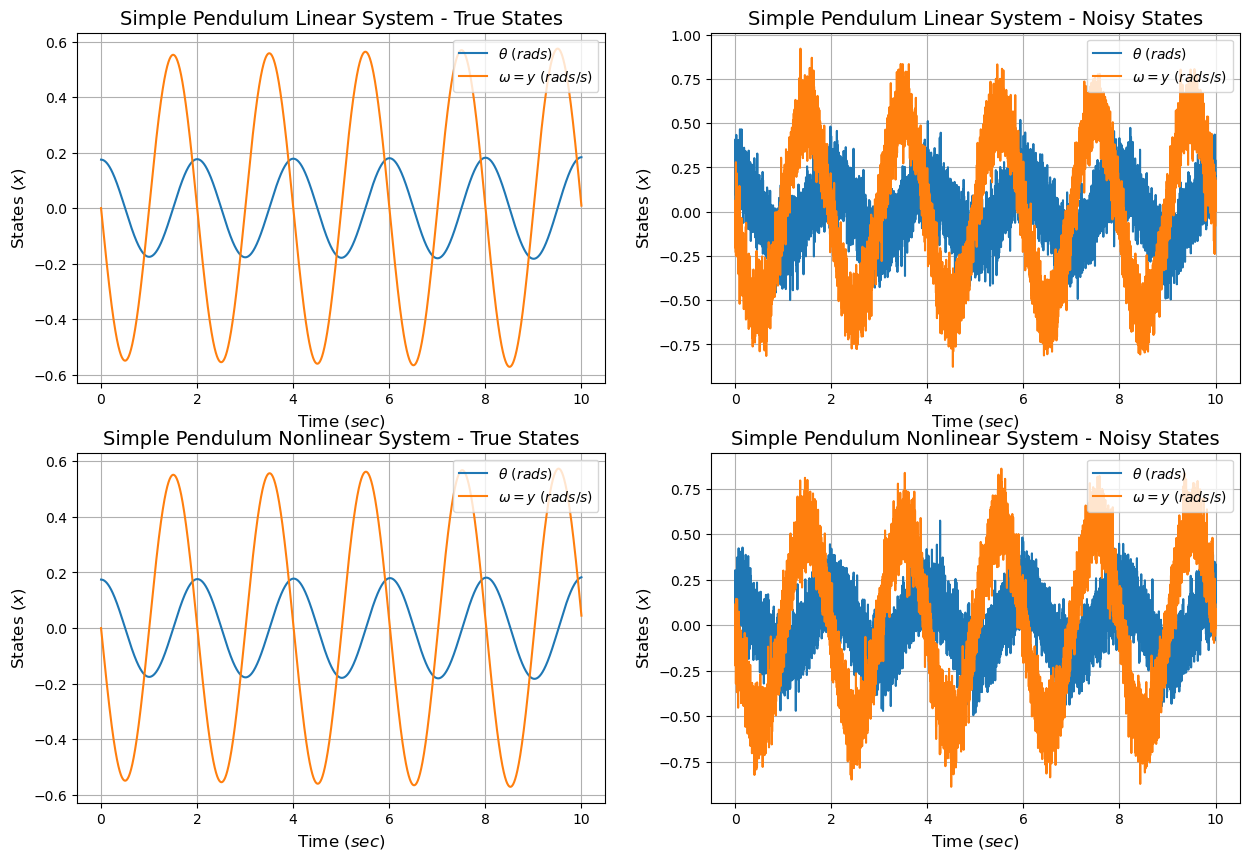

In [11]:
# Setting Figure Size
plt.rcParams['figure.figsize'] = [Plot_Width, Plot_Height]

# Plotting Figures
plt.figure()

# Plotting True States of Linear System
plt.subplot(221)
plt.plot(time_vector, x_sim_linear_true[:,:-1].transpose(), label=[r'$\theta$ $(rads)$', r'$\omega = y$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Linear System - True States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plotting Noisy States of Linear System
plt.subplot(222)
plt.plot(time_vector, x_sim_linear_noisy[:,:-1].transpose(), label=[r'$\theta$ $(rads)$', r'$\omega = y$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Linear System - Noisy States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plotting True States of Nonlinear System
plt.subplot(223)
plt.plot(time_vector, x_sim_nonlinear_true[:,:-1].transpose(), label=[r'$\theta$ $(rads)$', r'$\omega = y$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Nonlinear System - True States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plotting Noisy States of Nonlinear System
plt.subplot(224)
plt.plot(time_vector, x_sim_nonlinear_noisy[:,:-1].transpose(), label=[r'$\theta$ $(rads)$', r'$\omega = y$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Nonlinear System - Noisy States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)


### Simulation for Kalman Filter 

#### Simulation: Setup

In [19]:
## System Model Setup

# Model parameters
g_model = 9.
L_model = 0.95

# Model input
u_model = 0

## Filter Setup

# Initial Filter stae mean/covariance
theta_ini_model = 9.
omega_ini_model = 0.5

P_model = 1

# Filter process/measurement noise covariances
Q_model = 0
R_model = 0.1

#### Simulation: Basic Computations

In [20]:
## Model Computations

# Creating Continuous Time Model matrices
A = np.reshape(np.array([[0,1],[-(g_model/L_model),0]]), (2,2))
B = np.reshape(np.array([0,0]), (2,1))
C = np.reshape(np.array([0,1]), (1,2))

# Creating Discrete Time Model matrices
A_d = np.eye(2) + (ts*A)
B_d = ts*B
C_d = C

# Create the input vector
u_k_model = np.reshape(np.array([u_model]), (1,1)) 

## Filter Computations

# Convert initial theta to radians
theta_ini_rad_model = float(np.radians(theta_ini_model))

# Creating initial Filter mean vector
m_ini_model = np.reshape(np.array([theta_ini_rad_model, omega_ini_model]), (2,1))

# Creating initial Filter state covariance matrix
P_ini_model = P_model*np.eye(2)

# Create the model Q and R matrices
Q_d = np.reshape(np.array([[Q_model, 0],[0, Q_model]]), (2,2))
R_d = np.reshape(np.array([R_model]), (1,1))

#### Simulation: Creating the Kalman_Filter_Smoother Object 

In [21]:
# Creating Object for Linear Model
SimplePedulum_Linear_KF = KFS(A_d, B_d, C_d, m_ini_model, P_ini_model, Q_d, R_d)

# Creating Object for Noninear Model
SimplePedulum_Nonlinear_KF = KFS(A_d, B_d, C_d, m_ini_model, P_ini_model, Q_d, R_d)

#### Simulation: Time Evolution of Kalman Filter

In [22]:
# Initializing model filter state array to store time evolution
x_model_linear_filter = m_ini_model
x_model_nonlinear_filter = m_ini_model

# FOR LOOP: For each discrete time-step
for ii in range(y_sim_linear_noisy.shape[1]):
    
    ## For measurements coming from Linear System
    
    # Kalman Filter: Predict Step    
    m_k_, P_k_ = SimplePedulum_Linear_KF.Kalman_Predict(u_k_model)
    
    # Kalman Filter: Update Step
    v_k, S_k, K_k = SimplePedulum_Linear_KF.Kalman_Update(np.reshape(y_sim_linear_noisy[:,ii], (1,1)), m_k_, P_k_)    
    
    # Storing the Filtered states
    x_k_filter = SimplePedulum_Linear_KF.m_k
    x_model_linear_filter = np.hstack((x_model_linear_filter, x_k_filter))
    
    ## For measurements coming from Nonlinear System
    
    # Kalman Filter: Predict Step    
    m_k_, P_k_ = SimplePedulum_Nonlinear_KF.Kalman_Predict(u_k_model)
    
    # Kalman Filter: Update Step
    v_k, S_k, K_k = SimplePedulum_Nonlinear_KF.Kalman_Update(np.reshape(y_sim_nonlinear_noisy[:,ii], (1,1)), m_k_, P_k_)    
    
    # Storing the Filtered states
    x_k_filter = SimplePedulum_Nonlinear_KF.m_k
    x_model_nonlinear_filter = np.hstack((x_model_nonlinear_filter, x_k_filter))
    

#### Simulation: Plotting

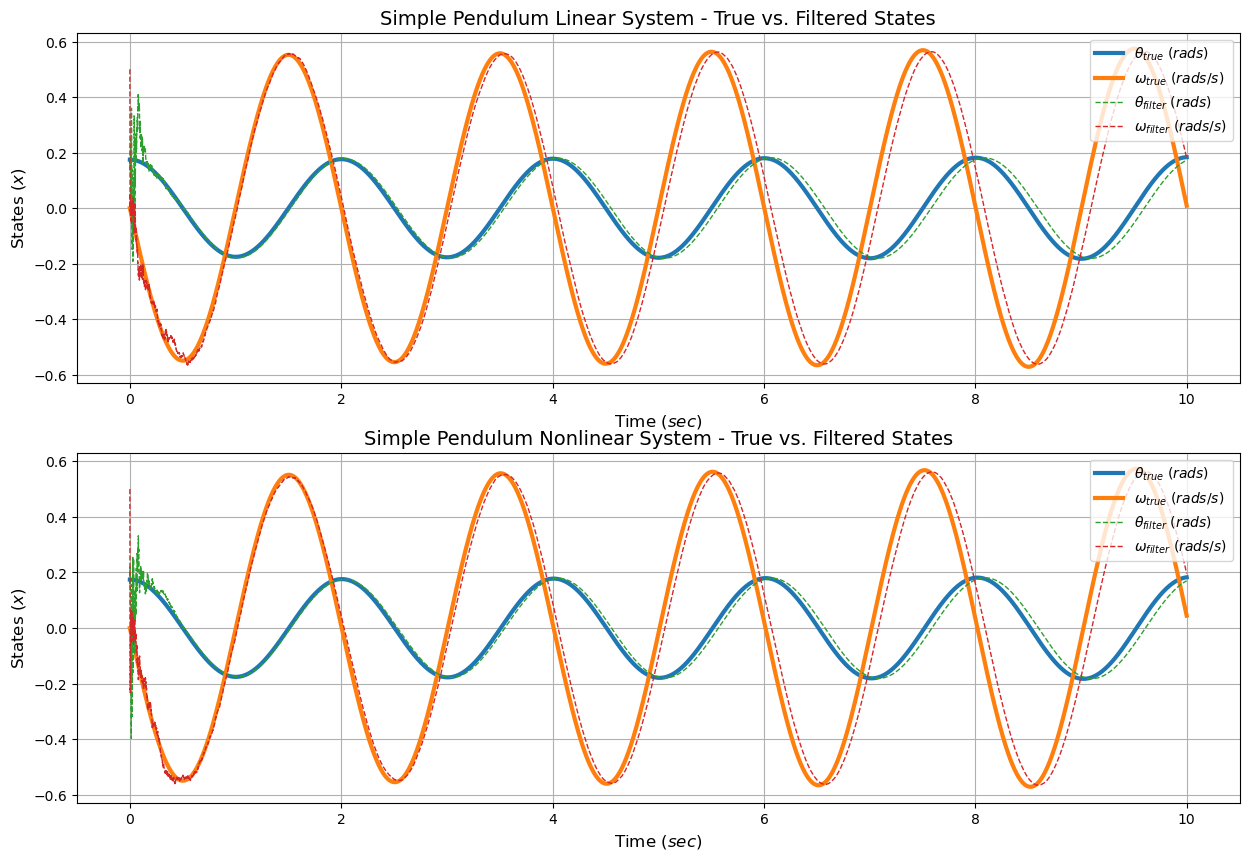

In [23]:
# Setting Figure Size
plt.rcParams['figure.figsize'] = [Plot_Width, Plot_Height]

# Plotting Figures
plt.figure()

# Plotting True vs. Filtered States of Linear System
plt.subplot(211)
plt.plot(time_vector, x_sim_linear_true[:,:-1].transpose(), linestyle='-', linewidth=3, label=[r'$\theta_{true}$ $(rads)$', r'$\omega_{true}$ $(rads/s)$'])
plt.plot(time_vector, x_model_linear_filter[:,:-2].transpose(), linestyle='--', linewidth=1, label=[r'$\theta_{filter}$ $(rads)$', r'$\omega_{filter}$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Linear System - True vs. Filtered States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plotting True vs. Filtered States of Nonlinear System
plt.subplot(212)
plt.plot(time_vector, x_sim_nonlinear_true[:,:-1].transpose(), linestyle='-', linewidth=3, label=[r'$\theta_{true}$ $(rads)$', r'$\omega_{true}$ $(rads/s)$'])
plt.plot(time_vector, x_model_nonlinear_filter[:,:-2].transpose(), linestyle='--', linewidth=1, label=[r'$\theta_{filter}$ $(rads)$', r'$\omega_{filter}$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Nonlinear System - True vs. Filtered States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

### Simulation for Kalman Smoother 

#### Simulation: Setup

In [24]:
## System Model Setup

# Model parameters
g_model = 9.
L_model = 0.95

# Model input
u_model = 0

## Filter Setup

# Initial Filter stae mean/covariance
theta_ini_model = 9.
omega_ini_model = 0.5

P_model = 1

# Filter process/measurement noise covariances
Q_model = 0
R_model = 0.1

#### Simulation: Basic Computations

In [25]:
## Model Computations

# Creating Continuous Time Model matrices
A = np.reshape(np.array([[0,1],[-(g_model/L_model),0]]), (2,2))
B = np.reshape(np.array([0,0]), (2,1))
C = np.reshape(np.array([0,1]), (1,2))

# Creating Discrete Time Model matrices
A_d = np.eye(2) + (ts*A)
B_d = ts*B
C_d = C

## Create the input vector list

# Create input vector
u_k_model = np.reshape(np.array([u_model]), (1,1)) 

# Create the input list
u_k_model_list = [] 

for ii in range(y_sim_linear_noisy.shape[1]):
    
    u_k_model_list.append(u_k_model)
    
## Create the measurement vector list

# For measurements from Linear System
y_sim_linear_noisy_list = []

for ii in range(y_sim_linear_noisy.shape[1]):
    
    y_sim_linear_noisy_list.append(np.reshape(y_sim_linear_noisy[:,ii], (1,1)))

# For measurements from Nonlinear System
y_sim_nonlinear_noisy_list = []

for ii in range(y_sim_nonlinear_noisy.shape[1]):
    
    y_sim_nonlinear_noisy_list.append(np.reshape(y_sim_nonlinear_noisy[:,ii], (1,1)))

## Filter Computations

# Convert initial theta to radians
theta_ini_rad_model = float(np.radians(theta_ini_model))

# Creating initial Filter mean vector
m_ini_model = np.reshape(np.array([theta_ini_rad_model, omega_ini_model]), (2,1))

# Creating initial Filter state covariance matrix
P_ini_model = P_model*np.eye(2)

# Create the model Q and R matrices
Q_d = np.reshape(np.array([[Q_model, 0],[0, Q_model]]), (2,2))
R_d = np.reshape(np.array([R_model]), (1,1))

#### Simulation: Creating the Kalman_Filter_Smoother Object

In [26]:
# Creating Object for Linear Model
SimplePedulum_Linear_KS = KFS(A_d, B_d, C_d, m_ini_model, P_ini_model, Q_d, R_d)

# Creating Object for Nonlinear Model
SimplePedulum_Nonlinear_KS = KFS(A_d, B_d, C_d, m_ini_model, P_ini_model, Q_d, R_d)

#### Simulation: Running Kalman Smoother

In [27]:
## For measurements coming from Linear System

# Kalman Smoother  
G_k_list, m_k_s_list, P_k_s_list = SimplePedulum_Linear_KS.Kalman_Smoother(u_k_model_list, y_sim_linear_noisy_list)   

# Storing the Filtered states
for ii in range(len(m_k_s_list)):
    
    if (ii == 0):
        
        x_model_linear_smoother = m_k_s_list[ii]
        
    else:
        
        x_model_linear_smoother = np.hstack((x_model_linear_smoother, m_k_s_list[ii]))

## For measurements coming from Nonlinear System

# Kalman Smoother    
G_k_list, m_k_s_list, P_k_s_list = SimplePedulum_Nonlinear_KS.Kalman_Smoother(u_k_model_list, y_sim_nonlinear_noisy_list) 

# Storing the Filtered states
for ii in range(len(m_k_s_list)):
    
    if (ii == 0):
        
        x_model_nonlinear_smoother = m_k_s_list[ii]
        
    else:
        
        x_model_nonlinear_smoother = np.hstack((x_model_nonlinear_smoother, m_k_s_list[ii]))


#### Simulation: Plotting

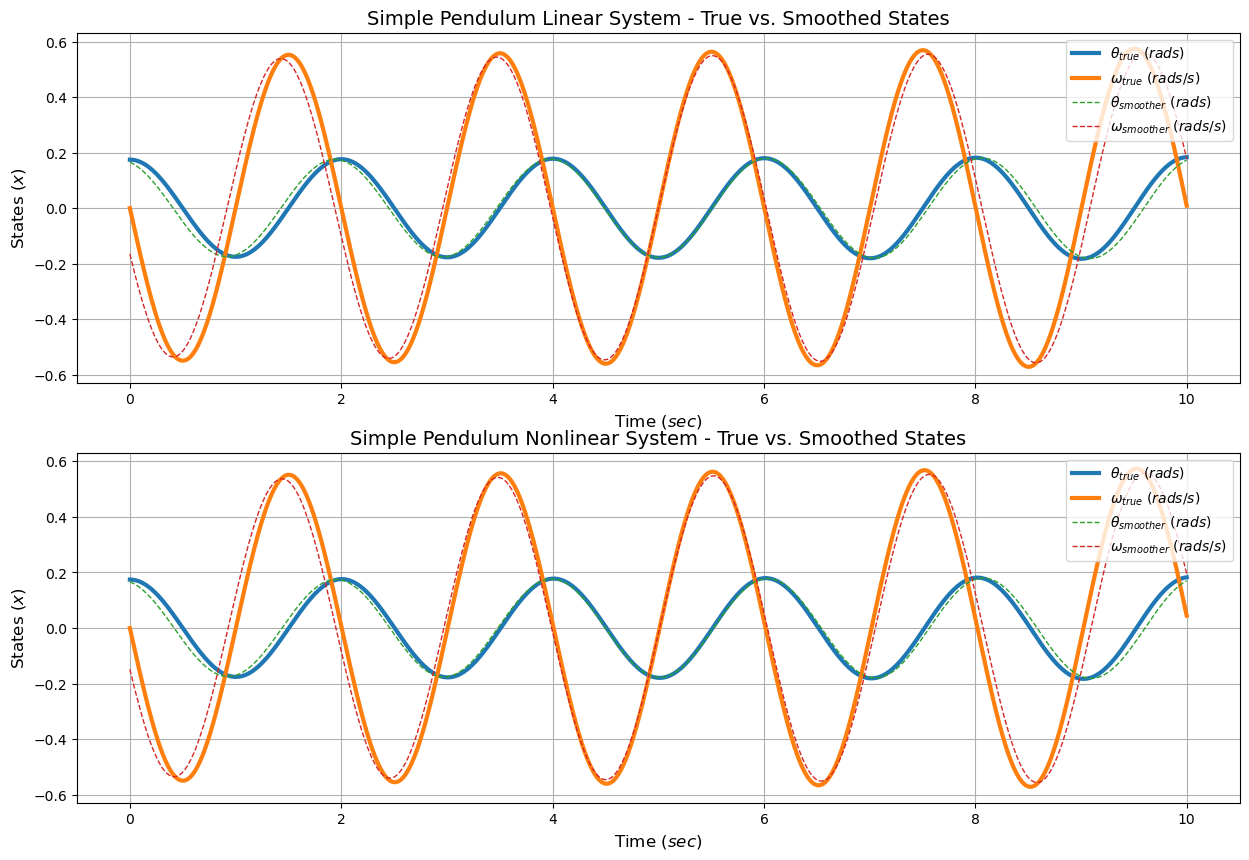

In [28]:
# Setting Figure Size
plt.rcParams['figure.figsize'] = [Plot_Width, Plot_Height]

# Plotting Figures
plt.figure()

# Plotting True vs. Filtered States of Linear System
plt.subplot(211)
plt.plot(time_vector, x_sim_linear_true[:,:-1].transpose(), linestyle='-', linewidth=3, label=[r'$\theta_{true}$ $(rads)$', r'$\omega_{true}$ $(rads/s)$'])
plt.plot(time_vector, x_model_linear_smoother[:,:-1].transpose(), linestyle='--', linewidth=1, label=[r'$\theta_{smoother}$ $(rads)$', r'$\omega_{smoother}$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Linear System - True vs. Smoothed States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plotting True vs. Filtered States of Nonlinear System
plt.subplot(212)
plt.plot(time_vector, x_sim_nonlinear_true[:,:-1].transpose(), linestyle='-', linewidth=3, label=[r'$\theta_{true}$ $(rads)$', r'$\omega_{true}$ $(rads/s)$'])
plt.plot(time_vector, x_model_nonlinear_smoother[:,:-1].transpose(), linestyle='--', linewidth=1, label=[r'$\theta_{smoother}$ $(rads)$', r'$\omega_{smoother}$ $(rads/s)$'])
plt.xlabel('Time ' + r'$(sec)$', fontsize=12)
plt.ylabel('States '+ r'$(x)$', fontsize=12)
plt.title('Simple Pendulum Nonlinear System - True vs. Smoothed States', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)